In [1]:
import os
import pandas as pd
from PIL import Image
from torchvision import transforms, models
from torchvision.models import DenseNet121_Weights
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
from tqdm import tqdm
from show import show_random_images
from show import show_misclassified_images
from show import imshow

# Define label mapping
LABEL_MAP = {'healthy': 0, 'dead': 1, 'bleached': 2}
LABEL_NAMES = list(LABEL_MAP.keys())

class CoralBleachingDataset(Dataset):
    def __init__(self, root_dir, metadata_file, transform=None,
                 image_col='name', label_col='label', location_col='location', date_col='date', watch_loca='CoralReefWatch location', tempe='SST@90th_HS'):
        self.root_dir = root_dir
        self.metadata = pd.read_csv(metadata_file)
        self.transform = transform
        self.image_col = image_col
        self.label_col = label_col
        self.location_col = location_col
        self.watch_loca = watch_loca
        self.tempe = tempe
        self.date_col = date_col

    def __len__(self):
        return len(self.metadata)

    def __getitem__(self, idx):
        # Reading data
        img_name = self.metadata.iloc[idx][self.image_col]
        label_str = self.metadata.iloc[idx][self.label_col]
        location = self.metadata.iloc[idx][self.location_col]
        date = self.metadata.iloc[idx][self.date_col]
        tempe = self.metadata.iloc[idx][self.tempe]

        # Map label string to integer
        label = LABEL_MAP[label_str]

        img_path = os.path.join(self.root_dir, label_str, img_name)
        if not os.path.exists(img_path):
            raise FileNotFoundError(f"Image file not found: {img_path}")

        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        # Returns a dictionary containing images, labels, locations and dates
        return {
            'image': image,
            'label': label,
            'location': location,
            'date': date,
            'SST@90th_HS': tempe
        }

def split_dataset(metadata_file, test_size=0.2, random_state=42):
    metadata = pd.read_csv(metadata_file)
    train_data, val_data = train_test_split(metadata, test_size=test_size, random_state=random_state)
    train_data.to_csv('train_metadata.csv', index=False)
    val_data.to_csv('val_metadata.csv', index=False)
    return 'train_metadata.csv', 'val_metadata.csv'

def collate_fn(batch):
    batch = [sample for sample in batch if sample is not None]
    return {
        'images': torch.stack([item['image'] for item in batch]),
        'labels': torch.tensor([item['label'] for item in batch]),
        'locations': [item['location'] for item in batch],
        'dates': [item['date'] for item in batch],
        'SST@90th_HS': [item['SST@90th_HS'] for item in batch]
    }

# Set the path
root_dir = '../outputs/images/cur+2.0'
metadata_file = os.path.join(root_dir, 'metadata.csv')

# Define image transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Adjust size according to model requirements
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # Normalization parameters for pre-trained models
                         std=[0.229, 0.224, 0.225])
])

# Split the dataset
train_metadata_file, val_metadata_file = split_dataset(metadata_file, test_size=0.2)

# Instantiate the datasets
train_dataset = CoralBleachingDataset(root_dir=root_dir, metadata_file=train_metadata_file, transform=transform)
val_dataset = CoralBleachingDataset(root_dir=root_dir, metadata_file=val_metadata_file, transform=transform)

# Use DataLoader to load data
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)

# Define the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load the pre-trained DenseNet model
model = models.densenet121(weights=DenseNet121_Weights.DEFAULT)

# Modify the classifier to match the number of classes
num_ftrs = model.classifier.in_features
model.classifier = nn.Linear(num_ftrs, len(LABEL_MAP))

# Move the model to the appropriate device
model = model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


Epoch 1/10: 100%|██████████| 82/82 [14:13<00:00, 10.41s/it]


Epoch 1/10 - Loss: 0.0761 - Acc: 0.9739


Validation: 100%|██████████| 21/21 [01:59<00:00,  5.68s/it]


Validation - Loss: 0.3686 - Acc: 0.8773
Displaying images after Epoch 1


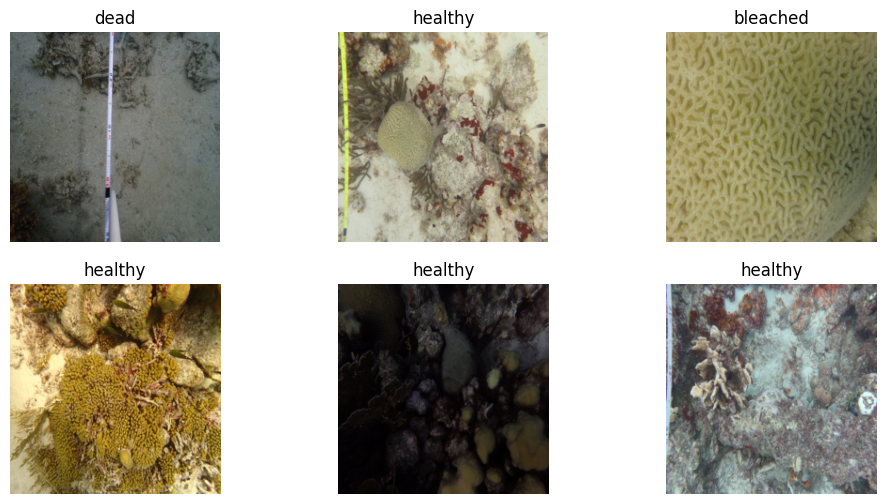

Epoch 2/10: 100%|██████████| 82/82 [13:10<00:00,  9.64s/it]


Epoch 2/10 - Loss: 0.0540 - Acc: 0.9823


Validation: 100%|██████████| 21/21 [01:54<00:00,  5.44s/it]


Validation - Loss: 0.4801 - Acc: 0.8896
Displaying images after Epoch 2


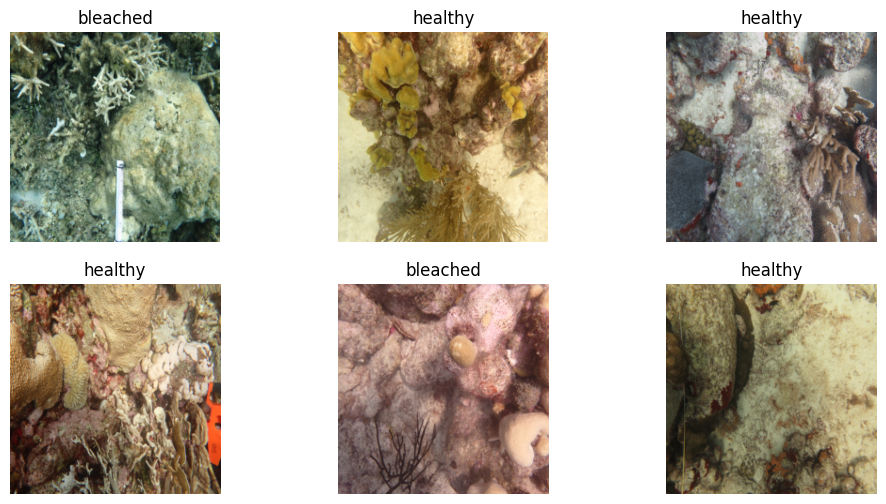

Epoch 3/10: 100%|██████████| 82/82 [13:07<00:00,  9.60s/it]


Epoch 3/10 - Loss: 0.0502 - Acc: 0.9812


Validation: 100%|██████████| 21/21 [01:47<00:00,  5.10s/it]


Validation - Loss: 0.4746 - Acc: 0.8773
Displaying images after Epoch 3


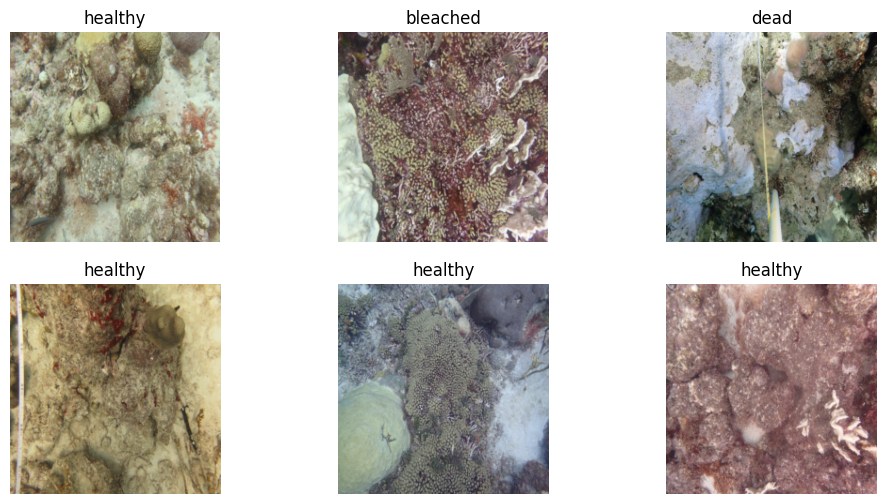

Epoch 4/10: 100%|██████████| 82/82 [12:35<00:00,  9.22s/it]


Epoch 4/10 - Loss: 0.0420 - Acc: 0.9866


Validation: 100%|██████████| 21/21 [01:51<00:00,  5.33s/it]


Validation - Loss: 0.5984 - Acc: 0.8574
Displaying images after Epoch 4


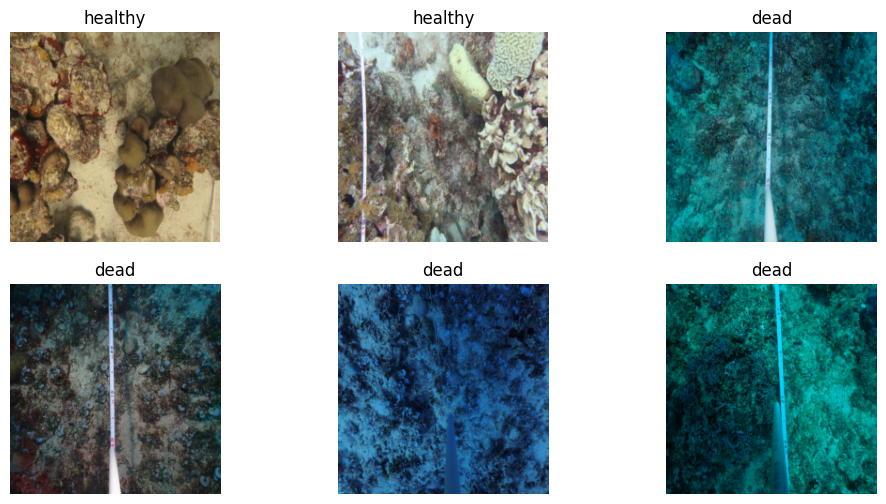

Epoch 5/10: 100%|██████████| 82/82 [13:01<00:00,  9.53s/it]


Epoch 5/10 - Loss: 0.0523 - Acc: 0.9793


Validation: 100%|██████████| 21/21 [02:03<00:00,  5.86s/it]


Validation - Loss: 0.9298 - Acc: 0.8282
Displaying images after Epoch 5


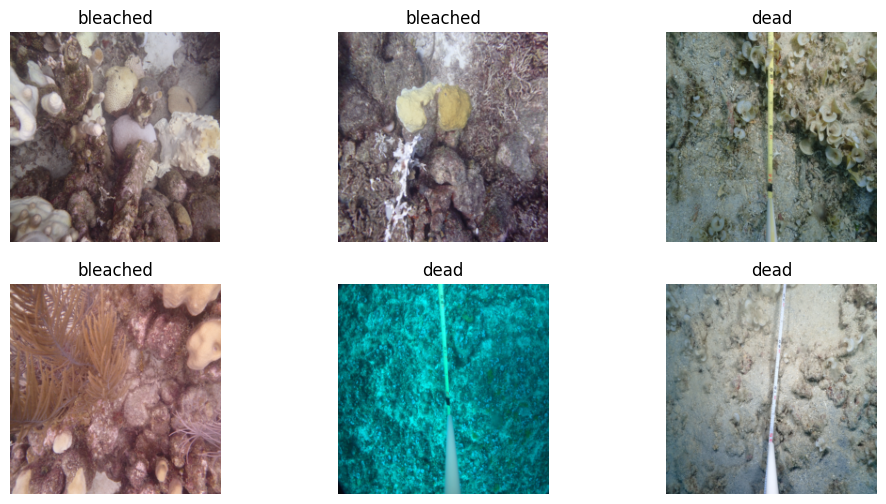

Epoch 6/10: 100%|██████████| 82/82 [11:15<00:00,  8.24s/it]


Epoch 6/10 - Loss: 0.0346 - Acc: 0.9850


Validation: 100%|██████████| 21/21 [01:36<00:00,  4.59s/it]


Validation - Loss: 0.5262 - Acc: 0.8727
Displaying images after Epoch 6


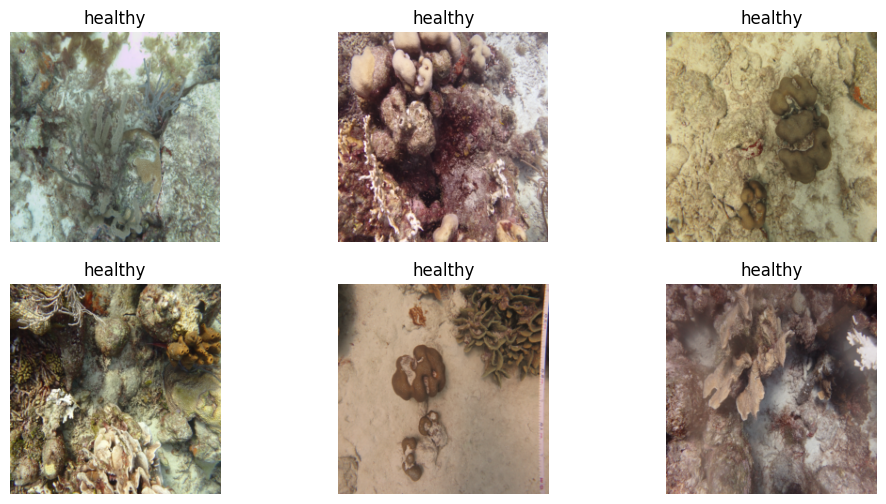

Epoch 7/10: 100%|██████████| 82/82 [11:27<00:00,  8.39s/it]


Epoch 7/10 - Loss: 0.0722 - Acc: 0.9739


Validation: 100%|██████████| 21/21 [01:58<00:00,  5.64s/it]


Validation - Loss: 0.5446 - Acc: 0.8819
Displaying images after Epoch 7


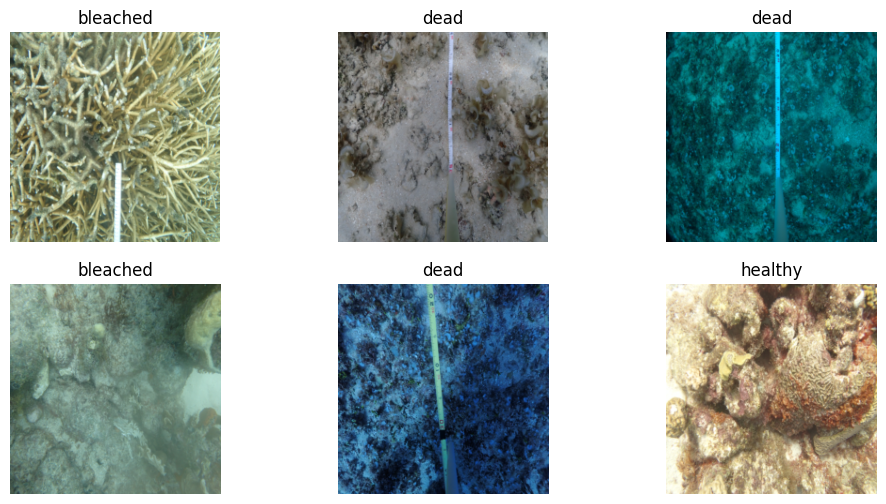

Epoch 8/10: 100%|██████████| 82/82 [11:21<00:00,  8.31s/it]


Epoch 8/10 - Loss: 0.0453 - Acc: 0.9835


Validation: 100%|██████████| 21/21 [01:35<00:00,  4.57s/it]


Validation - Loss: 0.4888 - Acc: 0.8482
Displaying images after Epoch 8


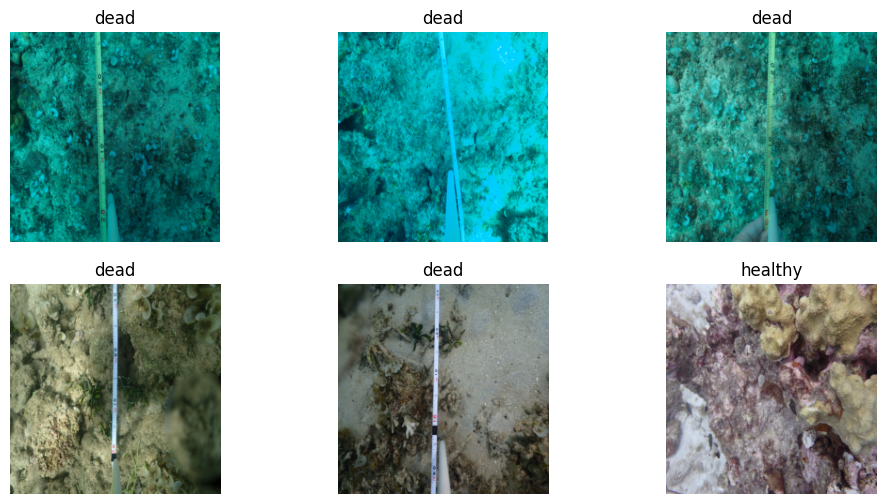

Epoch 9/10: 100%|██████████| 82/82 [11:23<00:00,  8.33s/it]


Epoch 9/10 - Loss: 0.0209 - Acc: 0.9939


Validation: 100%|██████████| 21/21 [01:40<00:00,  4.77s/it]


Validation - Loss: 0.4293 - Acc: 0.8819
Displaying images after Epoch 9


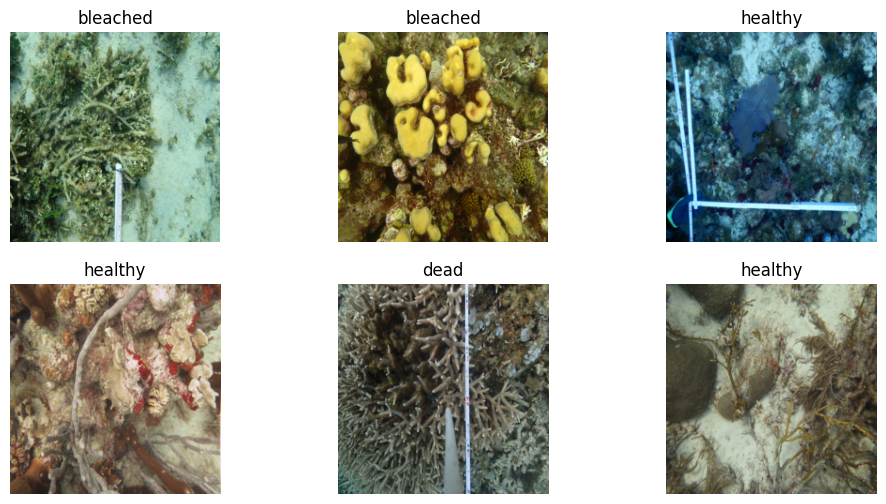

Epoch 10/10: 100%|██████████| 82/82 [11:34<00:00,  8.47s/it]


Epoch 10/10 - Loss: 0.0142 - Acc: 0.9954


Validation: 100%|██████████| 21/21 [01:35<00:00,  4.53s/it]


Validation - Loss: 0.6316 - Acc: 0.8482
Displaying images after Epoch 10


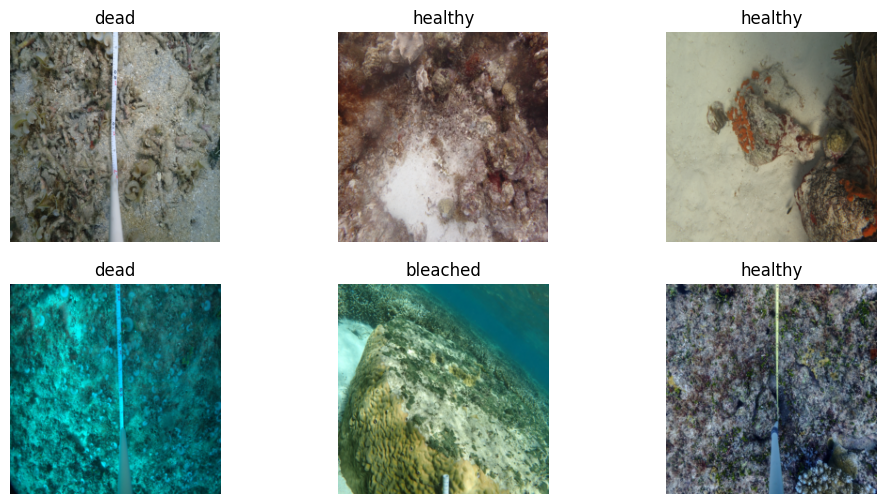

Training complete


In [12]:
all_preds = []
all_labels = []

# Training loop
num_epochs = 10  # Adjust as needed

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    running_corrects = 0
    total_samples = 0

    for batch in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}'):
        inputs = batch['images'].to(device)
        labels = batch['labels'].to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Statistics
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        total_samples += inputs.size(0)

    epoch_loss = running_loss / total_samples
    epoch_acc = running_corrects.double() / total_samples

    print(f'Epoch {epoch+1}/{num_epochs} - Loss: {epoch_loss:.4f} - Acc: {epoch_acc:.4f}')

    # Validation phase
    model.eval()
    val_running_loss = 0.0
    val_running_corrects = 0
    val_total_samples = 0

    # Lists to collect predictions and labels per epoch
    all_preds_epoch = []
    all_labels_epoch = []

    with torch.no_grad():
        for batch in tqdm(val_loader, desc='Validation'):
            inputs = batch['images'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            val_running_loss += loss.item() * inputs.size(0)
            val_running_corrects += torch.sum(preds == labels.data)
            val_total_samples += inputs.size(0)

            # Collect predictions and labels
            all_preds_epoch.extend(preds.cpu().numpy())
            all_labels_epoch.extend(labels.cpu().numpy())

    val_epoch_loss = val_running_loss / val_total_samples
    val_epoch_acc = val_running_corrects.double() / val_total_samples

    print(f'Validation - Loss: {val_epoch_loss:.4f} - Acc: {val_epoch_acc:.4f}')

    # Append to overall lists
    all_preds.extend(all_preds_epoch)
    all_labels.extend(all_labels_epoch)
    print(f'Displaying images after Epoch {epoch+1}')
    show_random_images(train_dataset)

print('Training complete')

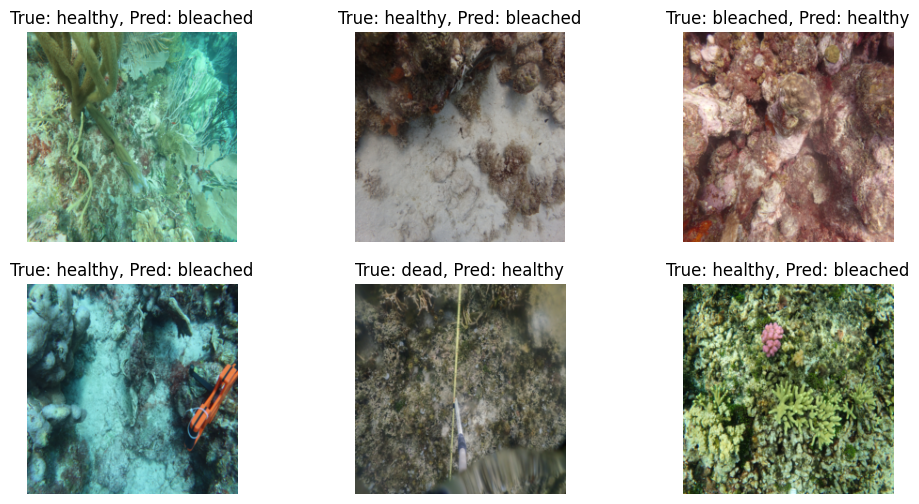

In [13]:
import numpy as np
import matplotlib.pyplot as plt

LABEL_NAMES = list(LABEL_MAP.keys())

def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    # Denormalize
    mean = np.array([0.485, 0.456, 0.406])
    std  = np.array([0.229, 0.224, 0.225])
    inp  = std * inp + mean
    inp  = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.axis('off')

def show_misclassified_images(model, dataset, num_images=6):
    model.eval()
    misclassified = []
    with torch.no_grad():
        for idx in range(len(dataset)):
            sample = dataset[idx]
            image = sample['image'].unsqueeze(0).to(device)
            label = sample['label']
            bioclim = sample.get('bioclim')
            if bioclim is not None:
                bioclim = bioclim.unsqueeze(0).to(device)
                output = model(image, bioclim)
            else:
                output = model(image)
            _, pred = torch.max(output, 1)
            pred = pred.item()
            if pred != label:
                misclassified.append((sample['image'], label, pred))
            if len(misclassified) >= num_images:
                break

    # Plot misclassified images
    fig = plt.figure(figsize=(12, 6))
    for i, (image, label, pred) in enumerate(misclassified):
        ax = fig.add_subplot(2, num_images // 2, i + 1, xticks=[], yticks=[])
        imshow(image)
        ax.set_title(f'True: {LABEL_NAMES[label]}, Pred: {LABEL_NAMES[pred]}')
    plt.show()

show_misclassified_images(model, val_dataset)

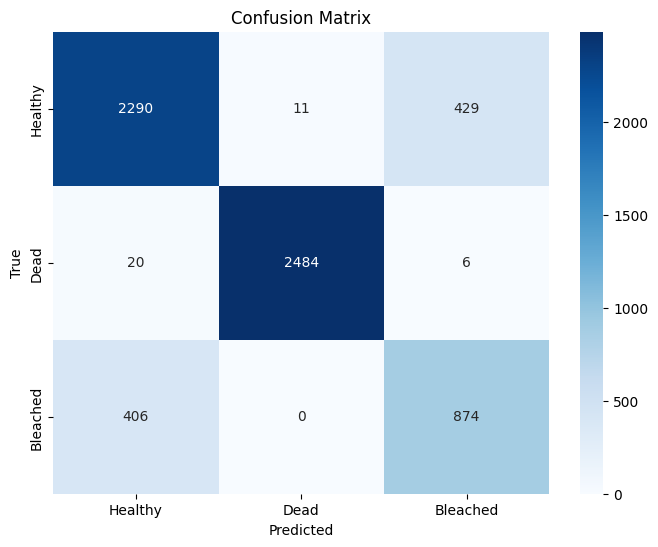

Classification Report:
              precision    recall  f1-score   support

     Healthy       0.84      0.84      0.84      2730
        Dead       1.00      0.99      0.99      2510
    Bleached       0.67      0.68      0.68      1280

    accuracy                           0.87      6520
   macro avg       0.84      0.84      0.84      6520
weighted avg       0.87      0.87      0.87      6520



In [14]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

LABEL_NAMES = ['Healthy', 'Dead', 'Bleached']

cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=LABEL_NAMES,
            yticklabels=LABEL_NAMES)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Classification report
report = classification_report(all_labels, all_preds, target_names=LABEL_NAMES)
print('Classification Report:')
print(report)


In [11]:
torch.save(model.state_dict(), 'coral_densenet.pth')